In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('../data.txt', sep='\s+')
df.atom_list = df.atom_list.apply(lambda x: list(map(int, x.split(','))))
atom_dict = {
    12: 'Mg',
    13: 'Al',
    20: 'Ca',
    22: 'Ti',
    23: 'V',
    24: 'Cr',
    25: 'Mn',
    26: 'Fe',
    27: 'Co',
    28: 'Ni',
    29: 'Cu',
    30: 'Zn',
    38: 'Sr',
    56: 'Ba',
}
for an, name in atom_dict.items():
    df[name] = df.atom_list.apply(lambda x: x.count(an) / len(x))
df_train = df[df.remark=='KS']
df_test = df[~(df.remark=='KS')]
X_train = df_train[atom_dict.values()]
y_train = df_train.Stabilized
X_test = df_test[atom_dict.values()]
y_test = df_test.Stabilized
X = df[atom_dict.values()]
y = df.Stabilized

# Random Forest

Using KS samples as training set.

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
clf = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
print(accuracy_score(y_test, clf.predict(X_test)))
print(roc_auc_score(y_test, clf.predict(X_test)))

0.8917525773195877
0.8207792207792208


5-fold cross validation

In [3]:
from sklearn.model_selection import cross_val_score
result = cross_val_score(clf, X, y, cv=5)
for i in range(10):
    result = np.r_[result, cross_val_score(clf, X, y, cv=5)]
print(np.mean(result), np.std(result))

0.845522497704316 0.05578283272511245


SHAP analysis

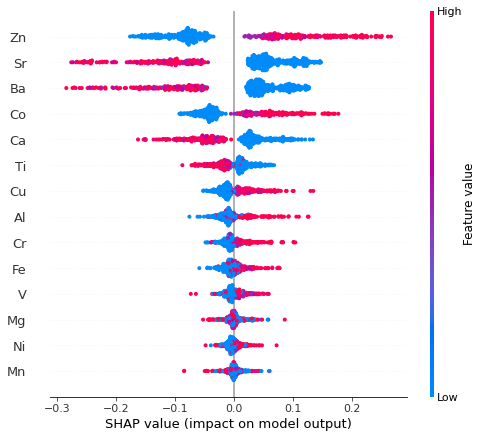

In [4]:
import shap
shap.initjs()
def shap_ana(clf, X, y):
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values[1], X)
    return explainer, shap_values
explainer, shap_values = shap_ana(clf, X, y)

(array([21.94068936,  7.25458277, 10.43952155,  3.71576191,  4.95434921,
         3.00799774,  2.47717461,  3.00799774,  1.06164626,  1.59246939,
         0.88470522,  1.59246939,  1.06164626,  0.        ,  1.94635148,
         0.17694104,  0.70776417,  0.35388209,  0.17694104,  1.06164626,
         0.53082313,  0.35388209,  0.        ,  0.35388209,  0.        ,
         0.        ,  0.17694104,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.17694104,  0.        ,  0.35388209,  0.        ,
         0.        ,  0.35388209,  0.        ,  0.17694104,  0.        ,
         0.        ,  0.17694104,  0.        ,  0.        ,  0.35388209]),
 array([-0.20203279, -0.18783279, -0.17363279, -0.15943279, -0.14523279,
        -0.13103279, -0.11683279, -0.10263279, -0.08843279, -0.07423279,
        -0.06003279, -0.04583279, -0.03163279, -0.01743279, -0.00323279,
         0.01096721,  0.02516721,  0.03936721,  0

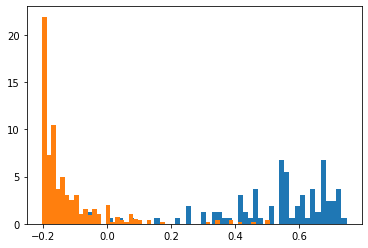

In [5]:
import matplotlib.pyplot as plt
plt.hist(shap_values[1][y == 1].sum(axis=1), bins=50, density=True)
plt.hist(shap_values[1][y == 0].sum(axis=1), bins=50, density=True)

# XGboost

Using KS samples as training set.

In [6]:
from xgboost import XGBClassifier
clf = XGBClassifier(n_estimators=100).fit(X_train, y_train)
print(accuracy_score(y_test, clf.predict(X_test)))
print(roc_auc_score(y_test, clf.predict(X_test)))

[15:24:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9123711340206185
0.8707792207792209


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


In [7]:
from xgboost import XGBRFClassifier
clf = XGBRFClassifier(n_estimators=20).fit(X_train, y_train)
print(accuracy_score(y_test, clf.predict(X_test)))
print(roc_auc_score(y_test, clf.predict(X_test)))

[15:24:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9175257731958762
0.8832792207792208


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


Bayesian optimization hyperparameters

In [8]:
from bayes_opt import BayesianOptimization 
from bayes_opt import UtilityFunction
import xgboost as xgb
def xgb_evaluate(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma,
                 alpha,
                 n_estimator
                ):
 
 
    params['min_child_weight'] = int(min_child_weight)
    params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
    params['max_depth'] = int(max_depth)
    params['subsample'] = max(min(subsample, 1), 0)
    params['gamma'] = max(gamma, 0)
    params['alpha'] = max(alpha, 0)
    params['n_estimator'] = int(n_estimator)
    clf = XGBRFClassifier(n_estimators=params['n_estimator'], 
                          min_child_weight=params['min_child_weight'],
                          colsample_bytree=params['colsample_bytree'],
                          max_depth=params['max_depth'],
                          subsample=params['subsample'],
                          gamma=params['gamma'],
                          reg_alpha=params['alpha'],
                          use_label_encoder=False,
                       ).fit(X_train, y_train)
    print("ROC-AUC", roc_auc_score(y_test, clf.predict(X_test)))
    return roc_auc_score(y_test, clf.predict(X_test))
    cv_result = xgb.cv(params, dtrain, num_boost_round=num_rounds, nfold=5,
             seed=random_state,
             callbacks=[xgb.callback.early_stop(50)])
 
 
    return cv_result['test-auc-mean'].values[-1]
 
 
# 定义相关参数
num_rounds = 3000
random_state = 2021
num_iter = 25
init_points = 5

params = {
    'eta': 0.1,
    'silent': 1,
    'eval_metric': 'auc',
    'verbose_eval': True,
    'seed': random_state
}
 
# 创建贝叶斯优化实例
# 并设定参数搜索范围
xgbBO = BayesianOptimization(xgb_evaluate, {'min_child_weight': (1, 20),
                                            'colsample_bytree': (0.8, 1),
                                            'max_depth': (5, 15),
                                            'subsample': (0.5, 1),
                                            'gamma': (0, 10),
                                            'alpha': (0, 10),
                                            'n_estimator': (10, 200)
                                            })
 
 
# 执行调优过程
xgbBO.maximize(init_points=init_points, n_iter=100)

|   iter    |  target   |   alpha   | colsam... |   gamma   | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
[15:24:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC-AUC 0.5
|  1        |  0.5      |  6.099    |  0.8171   |  5.15     |  8.142    |  14.14    |  122.1    |  0.5971   |
[15:24:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC-AUC 0.5
|  2        |  0.5      |  8.844    |  0.9649   |  0.771    |  5.928    |  5.338    |  188.5    |  0.7363   |
[15:24:57] WARNING: ../src/learn

[15:25:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC-AUC 0.7277597402597403
|  20       |  0.7278   |  2.239    |  0.8449   |  0.8203   |  14.7     |  2.023    |  99.85    |  0.9616   |
[15:25:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC-AUC 0.5
|  21       |  0.5      |  0.0      |  0.8      |  10.0     |  15.0     |  20.0     |  200.0    |  0.5      |
[15:25:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the

[15:25:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC-AUC 0.7402597402597404
|  38       |  0.7403   |  0.0      |  0.8      |  0.0      |  15.0     |  7.391    |  110.0    |  1.0      |
[15:25:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC-AUC 0.7777597402597403
|  39       |  0.7778   |  0.0      |  1.0      |  10.0     |  15.0     |  1.0      |  59.1     |  1.0      |
[15:25:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like

[15:25:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC-AUC 0.6935064935064935
|  56       |  0.6935   |  4.468    |  0.9344   |  0.2322   |  7.647    |  1.023    |  138.0    |  0.8935   |
[15:25:13] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC-AUC 0.6125
|  57       |  0.6125   |  10.0     |  1.0      |  0.0      |  15.0     |  1.0      |  71.76    |  1.0      |
[15:25:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore 

[15:25:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC-AUC 0.5
|  74       |  0.5      |  10.0     |  1.0      |  0.0      |  5.0      |  20.0     |  58.88    |  1.0      |
[15:25:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC-AUC 0.7777597402597403
|  75       |  0.7778   |  0.0      |  0.8      |  10.0     |  5.0      |  1.0      |  161.8    |  1.0      |
[15:25:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the

[15:25:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC-AUC 0.787012987012987
|  92       |  0.787    |  0.0      |  1.0      |  0.0      |  5.0      |  1.0      |  155.7    |  0.5      |
[15:25:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC-AUC 0.7777597402597403
|  93       |  0.7778   |  0.0      |  0.8      |  10.0     |  5.0      |  1.0      |  142.0    |  1.0      |
[15:25:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like 

The hyperparameters used above is already very good.

5-fold cross validation

In [9]:
result = cross_val_score(clf, X, y, cv=5)
for i in range(10):
    result = np.r_[result, cross_val_score(clf, X, y, cv=5)]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[15:25:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:25:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:25:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:25:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and w

[15:25:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:25:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:25:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:25:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
The use of label encoder in XGBClassifier is deprecated and w

[15:25:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:25:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:25:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:25:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [10]:
print(np.mean(result), np.std(result))

0.8876969696969698 0.028273620434753705


SHAP analysis

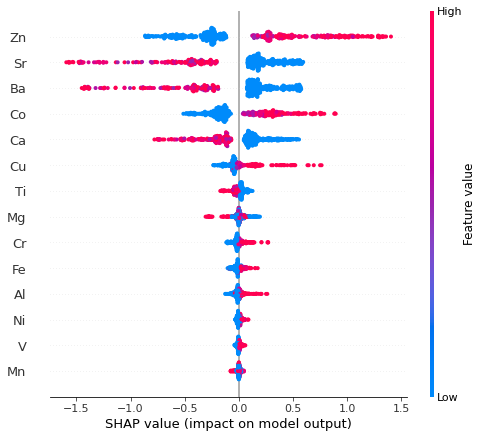

In [11]:
def shap_ana(clf, X, y):
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X)
    return explainer, shap_values
explainer, shap_values = shap_ana(clf, X, y)

(array([6.96624224, 2.19041637, 0.8258954 , 0.96952856, 0.17954233,
        0.68226084, 0.25135936, 0.21545079, 0.1077254 , 0.        ,
        0.10772542, 0.03590847, 0.07181695, 0.07181694, 0.25135926,
        0.        , 0.14363386, 0.14363386, 0.1077254 , 0.        ,
        0.07181693, 0.07181693, 0.07181693, 0.        , 0.        ,
        0.        , 0.07181693, 0.03590847, 0.03590847, 0.03590847,
        0.07181693, 0.03590847, 0.07181693, 0.14363411, 0.03590847,
        0.        , 0.03590847, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.03590847, 0.03590847,
        0.        , 0.        , 0.        , 0.03590847, 0.07181693]),
 array([-0.79609245, -0.7261211 , -0.6561498 , -0.58617854, -0.5162072 ,
        -0.4462359 , -0.37626457, -0.30629328, -0.23632196, -0.16635063,
        -0.09637932, -0.02640801,  0.0435633 ,  0.11353461,  0.18350592,
         0.25347725,  0.32344854,  0.39341986,  0.46339118,  0.5333625 ,
         0.6033338 ,  0.67

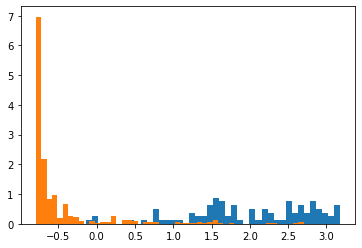

In [12]:
plt.hist(shap_values[y == 1].sum(axis=1), bins=50, density=True)
plt.hist(shap_values[y == 0].sum(axis=1), bins=50, density=True)

In [13]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X)

In [14]:
shap.force_plot(explainer.expected_value, shap_values, X)

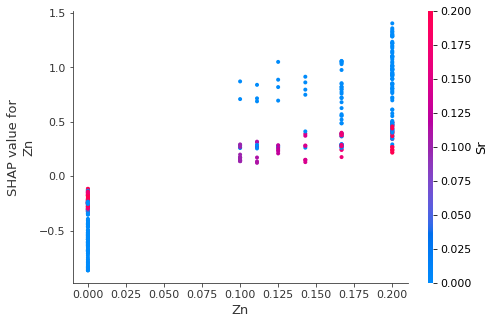

In [15]:
shap.dependence_plot("Zn", shap_values, X, interaction_index='Sr')

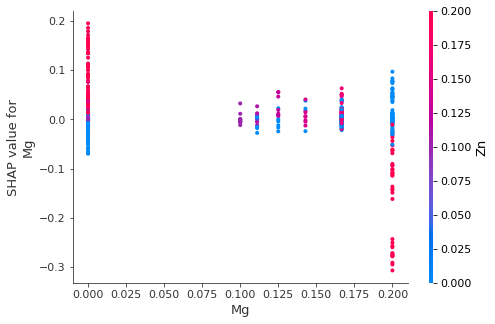

In [16]:
shap.dependence_plot("Mg", shap_values, X)

In [17]:
shap_interaction_values = shap.TreeExplainer(clf).shap_interaction_values(X)

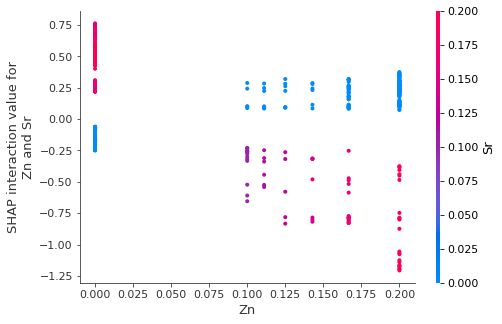

In [18]:
shap.dependence_plot(("Zn", "Sr"), shap_interaction_values, X)